In [1]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from imblearn.over_sampling import SMOTE
import pywt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#ML Classifiers
from sklearn.neighbors import KNeighborsClassifier #K-Neighbors classifier
from sklearn.tree import DecisionTreeClassifier #Decision Tree classifier
from sklearn.svm import SVC # Support Vector Machines classifier
#from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

#Boosting classifiers
import xgboost as xgb
from sklearn.ensemble import *

#Evaluation metrics
from sklearn import metrics #to check for error and accuracy of the model




**Data Uploading**

In [3]:
#If using google colab
#Upload data from local drive


from google.colab import files
uploaded = files.upload()

Saving data.csv to data.csv


In [4]:
#Load data

eegdatafile = 'data.csv'

data = pd.read_csv(eegdatafile, header=0)



In [5]:
data.head()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


In [6]:
#In the column y, replace values greater than 1 with 0 to make it a binary classification
#1 - epileptic seizure, 0- control (which replaces 2,3,4,5 - subjects with no epileptic seizure)

data.loc[data["y"] > 1, "y"] = 0

In [7]:
data.head()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,0
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,0
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,0
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11500 entries, 0 to 11499
Columns: 180 entries, Unnamed: 0 to y
dtypes: int64(179), object(1)
memory usage: 15.8+ MB


In [9]:
#Check if data is imbalanced

#ct = sns.countplot(data['y'], label = "Count")
data['y'].value_counts()


,count
y,
0,9200
1,2300


**Preprocessing**

In [10]:
#Drop the first column

data = data.drop("Unnamed: 0", axis=1)




In [11]:
#Generate the Independent variables

X = data.values
X= X[:,0:-1]

In [12]:
#Generate the Dependent variable

y= data['y'].values


In [13]:
#Data is imbalanced so oversample the minority class using SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [16]:
#Plot transformed data
#ct = sns.countplot(y, label = "Count")
print(len(np.where(y==0)[0]),len(np.where(y==1)[0]))


9200 9200


In [20]:
#Dimensional Reductionality and Feature Extraction
#Apply Wavelet Transforms to capture time frequency patterns

# Save original X before wavelet transform for comparison
X_original = X.copy()

#Apply wavelet transforms to extract features

threshold = 0.1
coeff_list = []
wavelet = pywt.Wavelet('sym4')
for row in X:
    coeff = pywt.dwt(row, wavelet)
    coeff_list.append(coeff)

# Apply thresholding (soft thresholding example)
thresholded_coeff_list = []
for coeff in coeff_list:
    thresholded_coeff = [pywt.threshold(c, mode='soft', value=threshold) for c in coeff]
    thresholded_coeff_list.append(thresholded_coeff)

# Reduced dimension data (keeping only approximation coefficients)
reduced_data = np.array([coeff[0] for coeff in thresholded_coeff_list])
print("Original data shape:", X.shape)
print("Reduced data shape:", reduced_data.shape)



Original data shape: (18400, 178)
Reduced data shape: (18400, 92)


In [21]:
#Apply PCA to remove redundancies in wavelet coeeficients


# Using the reduced_data from wavelet transform
wavelet_pca = PCA(n_components=0.95)  # Keep 95% variance after wavelet
X_wavelet_pca = wavelet_pca.fit_transform(reduced_data)

print(f"Original shape: {X_original.shape}")
print(f"After wavelet: {reduced_data.shape}")
print(f"After wavelet + PCA: {X_wavelet_pca.shape}")
print(f"Total reduction: {X_original.shape[1]} -> {X_wavelet_pca.shape[1]} features")
print(f"Reduction ratio: {X_wavelet_pca.shape[1]/X_original.shape[1]:.2%}")

Original shape: (18400, 178)
After wavelet: (18400, 92)
After wavelet + PCA: (18400, 38)
Total reduction: 178 -> 38 features
Reduction ratio: 21.35%


In [33]:
#Normalize the data
#Xs= X_wavelet_pca
#Xs = (Xs-Xs.mean())/Xs.std()
#Xs.shape

In [32]:
#Apply standard scaler
X= X_wavelet_pca
scalar = StandardScaler()
X = scalar.fit_transform(X)
X.shape


(18400, 38)

In [34]:
#Splitting dataset into train and test set

#Split data into train and remaining dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.80,stratify=y,random_state=1)

#Split remaining data into test and validation with 50% split
#X_val, X_test, y_val, y_test = train_test_split(X_re, y_re, test_size=0.5, stratify=y_re,random_state=1)

In [35]:
print(X.shape, y.shape)

(18400, 38) (18400,)


In [36]:
#Create Function to fit and predict model

def fitPredictModel(model):
    model.fit(X_train, y_train)
    prediction = model.predict(X_val)
    print("Accuracy: ",metrics.accuracy_score(y_val,prediction))
    print("Balanced Accuracy: ",metrics.balanced_accuracy_score(y_val,prediction))
    print("F1 score: ",metrics.f1_score(y_val,prediction))
    print("Precision: ",metrics.precision_score(y_val,prediction))
    print("Recall: ",metrics.recall_score(y_val,prediction))
    cm = metrics.confusion_matrix(y_val,prediction)
    #Visualize the confusion matrix
    sns.heatmap(cm,annot=True,fmt="d", cmap = 'Blues')



Standard Classifiers

Accuracy:  0.9589673913043478
Balanced Accuracy:  0.9589673913043478
F1 score:  0.9584594222833562
Precision:  0.9704735376044569
Recall:  0.9467391304347826


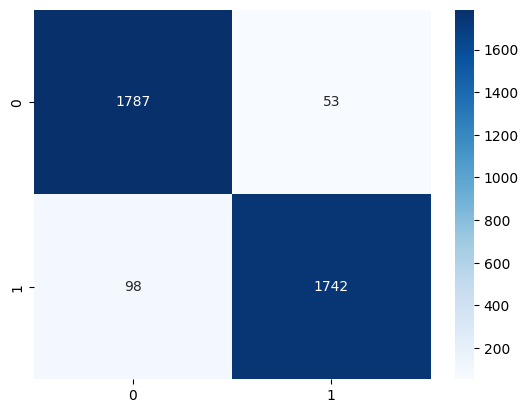

In [37]:
#Train models
#Support Vector Machines Classifier

SVC_model = SVC(kernel = 'rbf', random_state = 42)
fitPredictModel(SVC_model)




Accuracy:  0.9709239130434782
Balanced Accuracy:  0.9709239130434784
F1 score:  0.9712288249529444
Precision:  0.961149547631719
Recall:  0.9815217391304348


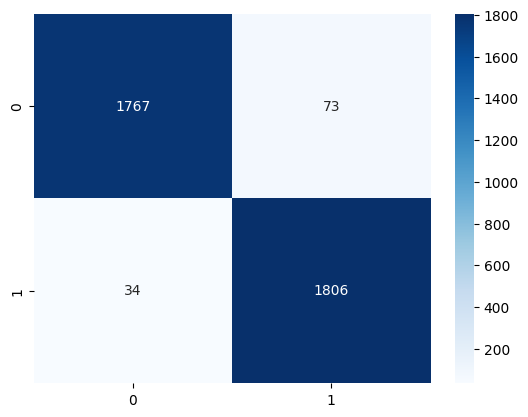

In [38]:
#Random Forest Classifier

RF_model=RandomForestClassifier(n_estimators=10)
fitPredictModel(RF_model)

Accuracy:  0.99375
Balanced Accuracy:  0.99375
F1 score:  0.9937516979081771
Precision:  0.993481803367735
Recall:  0.9940217391304348


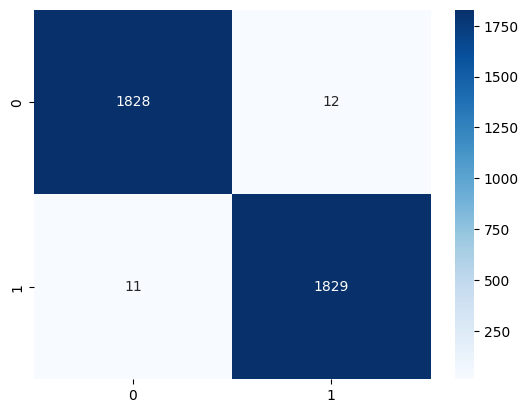

In [39]:
#K-Nearest Neighbors Classifier

KNN_model = KNeighborsClassifier(n_neighbors = 1)
fitPredictModel(KNN_model)

Accuracy:  0.9375
Balanced Accuracy:  0.9375
F1 score:  0.9367088607594937
Precision:  0.9487179487179487
Recall:  0.925


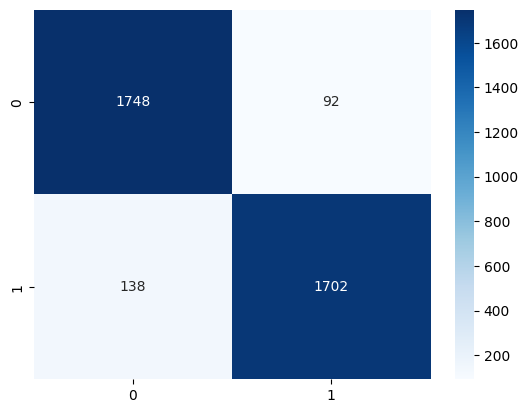

In [40]:
#Decision Tree Classifier
DT_model = DecisionTreeClassifier(max_depth=10)
fitPredictModel(DT_model)


Accuracy:  0.9171195652173914
Balanced Accuracy:  0.9171195652173914
F1 score:  0.9134260573374965
Precision:  0.9560308972073678
Recall:  0.8744565217391305


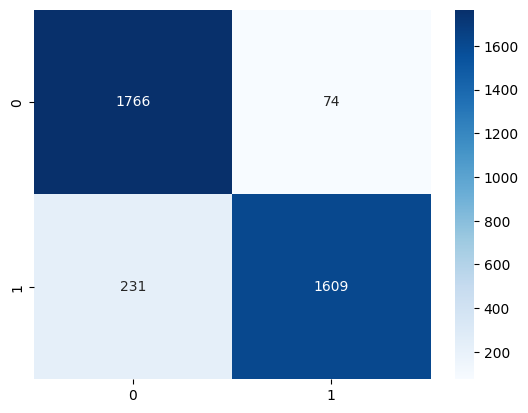

In [41]:
#Naive Bayes Classifier
gnb_model = GaussianNB()
fitPredictModel(gnb_model)

**Boosting Algorithms**

Accuracy:  0.9807065217391304
Balanced Accuracy:  0.9807065217391304
F1 score:  0.9808676906494206
Precision:  0.9727418492784607
Recall:  0.9891304347826086


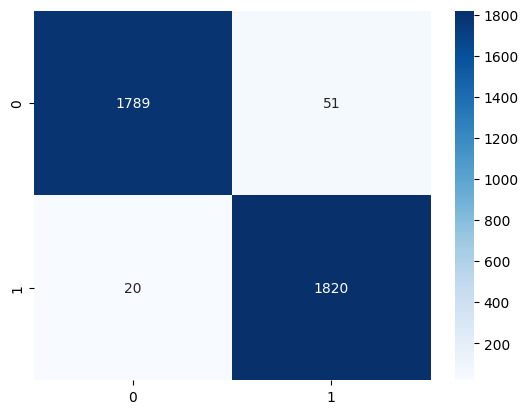

In [43]:
#XGBoost
xgb_boost = xgb.XGBClassifier()
fitPredictModel(xgb_boost)

Accuracy:  0.9353260869565218
Balanced Accuracy:  0.9353260869565216
F1 score:  0.933852140077821
Precision:  0.9556313993174061
Recall:  0.9130434782608695


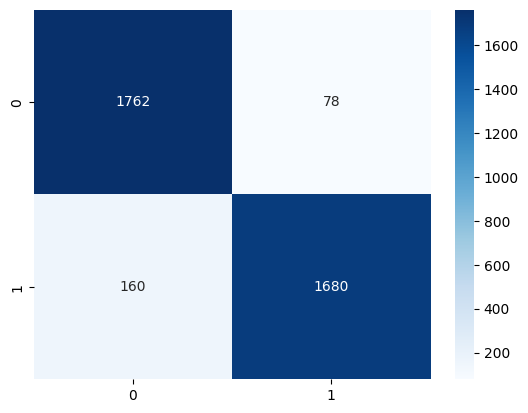

In [44]:
#Adaptive boosting

ada_boost = AdaBoostClassifier()
fitPredictModel(ada_boost)